## DCA Forecasting + Backtesting (Volve)

This notebook implements a reservoir-engineering baseline: **Decline Curve Analysis (DCA)**.

We will:
- Choose a target series (by default `q_oil_eff`)
- Fit **exponential** and **hyperbolic** decline models
- Select the best model per well using AIC
- Backtest via time-based splits
- Export plots and a small metrics table under `reports/`



In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def find_project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    markers = {"Equinor_Job.md", "requirements.txt", "src"}
    for cand in [p] + list(p.parents):
        hits = 0
        for m in markers:
            if (cand / m).exists():
                hits += 1
        if hits >= 2:
            return cand
    return p


PROJECT_ROOT = find_project_root()
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from volve_forecast.dca import fit_best  # noqa: E402

DATA_PATH = PROJECT_ROOT / "data" / "processed" / "volve_daily.csv"
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Data:", DATA_PATH)


df = pd.read_csv(DATA_PATH)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values(["well", "date"]).reset_index(drop=True)

# Choose target; q_oil_eff is uptime-corrected (flowing rate) and usually more stable for DCA.
target = "q_oil_eff"

print("Target:", target)
print("Wells:", df["well"].unique().tolist())

df.head()


Project root: /Users/taief/Desktop/Norway Dam/equinor
Data: /Users/taief/Desktop/Norway Dam/equinor/data/processed/volve_daily.csv
Target: q_oil_eff
Wells: ['NO 15/9-F-1 C', 'NO 15/9-F-11 H', 'NO 15/9-F-12 H', 'NO 15/9-F-14 H', 'NO 15/9-F-15 D', 'NO 15/9-F-4 AH', 'NO 15/9-F-5 AH']


,well,date,q_oil,q_gas,q_water,on_stream_hrs,q_oil_eff,q_gas_eff,q_water_eff,avg_downhole_pressure,avg_whp,avg_choke_size_p,dp_choke_size,bore_wi_vol,flow_kind,well_type
0,NO 15/9-F-1 C,2014-04-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,production,WI
1,NO 15/9-F-1 C,2014-04-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00000,1.003059,0.00000,0.0,production,OP
2,NO 15/9-F-1 C,2014-04-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00000,0.979008,0.00000,0.0,production,OP
3,NO 15/9-F-1 C,2014-04-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00000,0.545759,0.00000,0.0,production,OP
4,NO 15/9-F-1 C,2014-04-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.37614,33.09788,1.215987,33.07195,0.0,production,OP


In [2]:
# Pick a showcase well automatically (longest continuous flowing segment)

def best_well_by_flow_segment(df: pd.DataFrame, target: str) -> str:
    flow = (df["on_stream_hrs"].fillna(0) > 0) & (df[target].fillna(0) > 0)
    best = None
    best_key = (-1, -1.0)

    for well, d in df.assign(is_flow=flow).groupby("well"):
        d = d.sort_values("date")
        seg_id = (d["is_flow"] != d["is_flow"].shift(1)).cumsum()
        d = d.assign(seg_id=seg_id)
        flow_segs = d[d["is_flow"]].groupby("seg_id")
        if len(flow_segs) == 0:
            continue
        seg_stats = flow_segs.agg(n_days=("date", "count"), mean_q=(target, "mean"))
        top = seg_stats.sort_values(["n_days", "mean_q"], ascending=[False, False]).iloc[0]
        key = (int(top.n_days), float(top.mean_q))
        if key > best_key:
            best_key = key
            best = well

    if best is None:
        raise ValueError("Could not select a best well (no flowing segments found).")
    return best


showcase_well = best_well_by_flow_segment(df, target)
print("Showcase well:", showcase_well)



Showcase well: NO 15/9-F-14 H


Showcase flowing rows: 2723

Note: a small n_test is usually NOT missing Excel data. It typically means the well was shut-in near the end,
so only a few flowing-day samples remain in the last 90 calendar days.


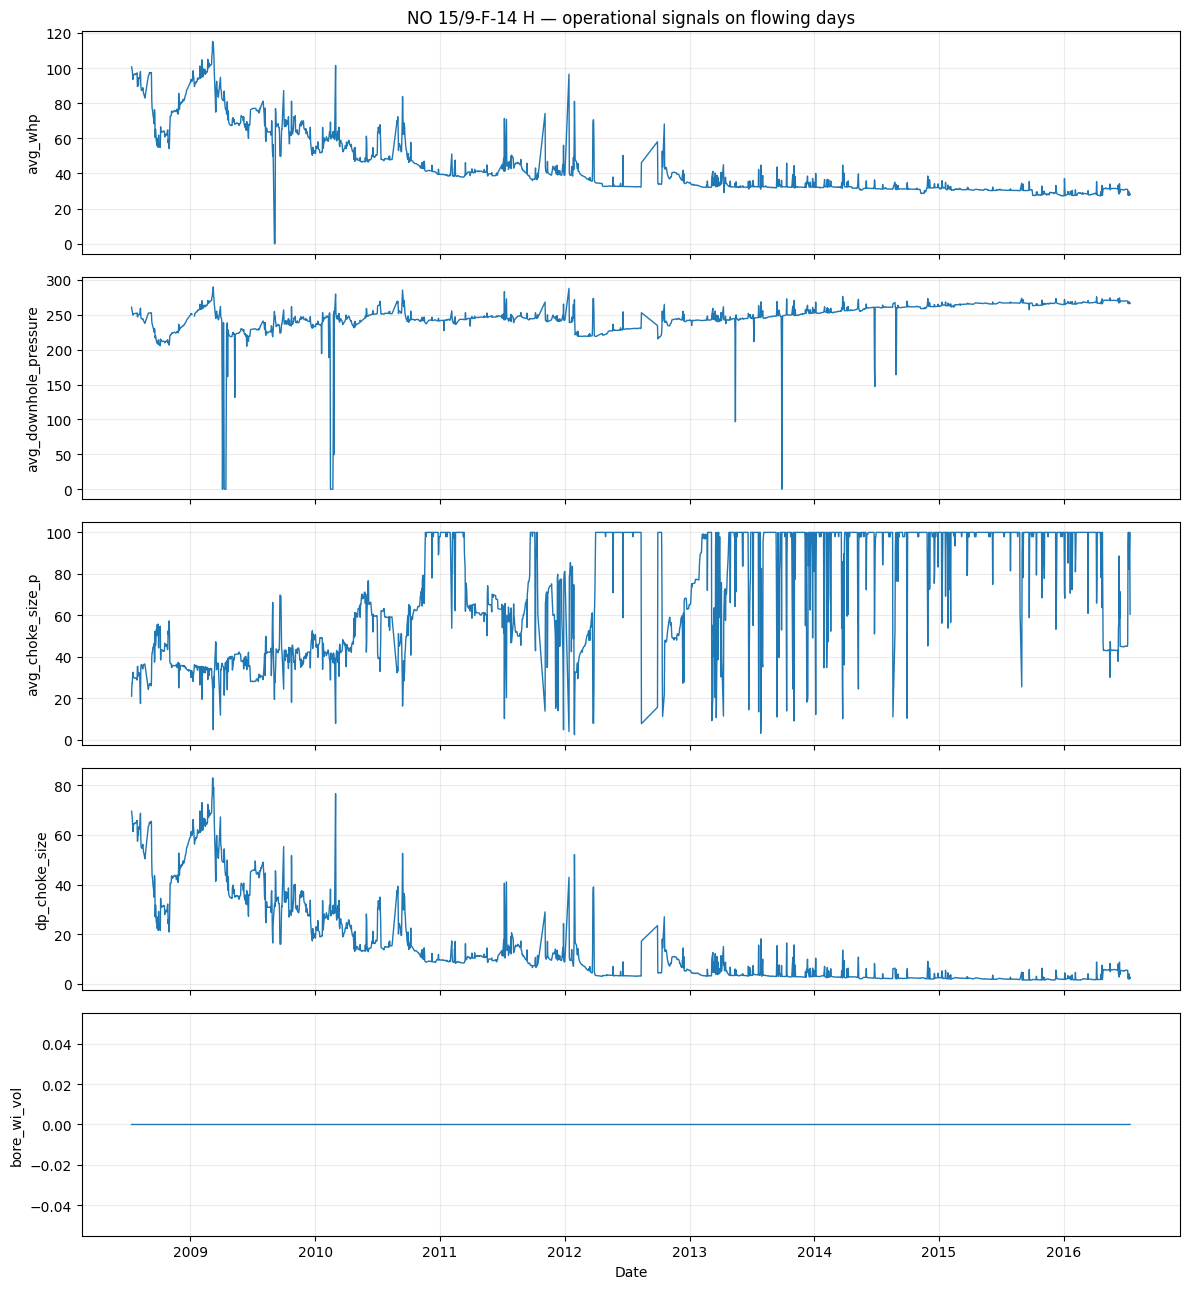

Saved: /Users/taief/Desktop/Norway Dam/equinor/reports/figures/ops_signals_NO_15_9-F-14_H.png


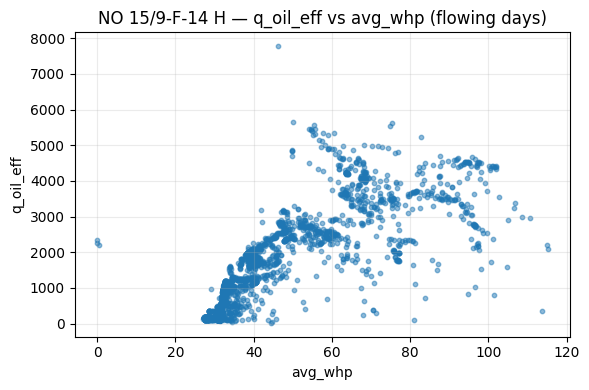

Saved: /Users/taief/Desktop/Norway Dam/equinor/reports/figures/ops_scatter_NO_15_9-F-14_H_avg_whp.png


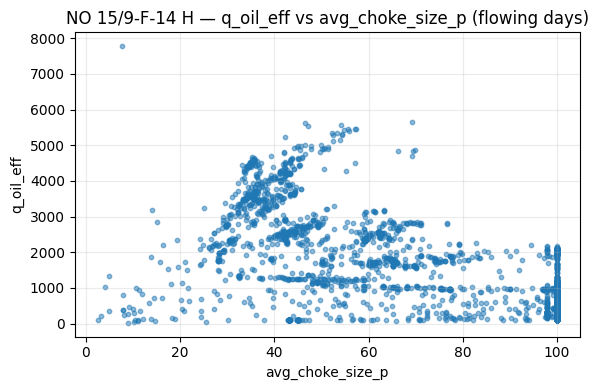

Saved: /Users/taief/Desktop/Norway Dam/equinor/reports/figures/ops_scatter_NO_15_9-F-14_H_avg_choke_size_p.png


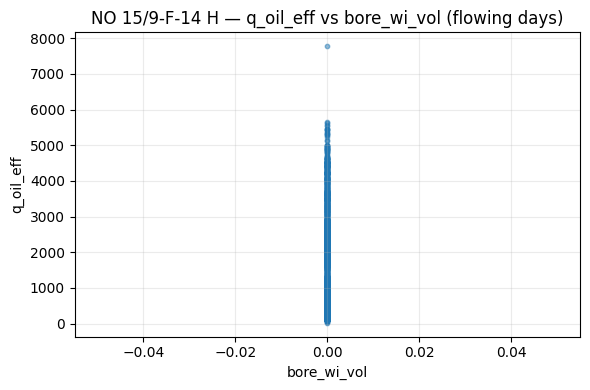

Saved: /Users/taief/Desktop/Norway Dam/equinor/reports/figures/ops_scatter_NO_15_9-F-14_H_bore_wi_vol.png


In [3]:
# Prepare a clean modeling frame: keep only flowing days for DCA

import re


def safe_filename(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", s).strip("_")


def make_flowing_series(df: pd.DataFrame, well: str, target: str) -> pd.DataFrame:
    d = df[df["well"] == well].copy().sort_values("date")
    # Flowing definition: uptime>0 and target>0
    d = d[(d["on_stream_hrs"].fillna(0) > 0) & (d[target].fillna(0) > 0)].copy()
    d = d.dropna(subset=["date", target])
    d = d.sort_values("date")
    # Time index in calendar days since first FLOWING observation
    d["t_days"] = (d["date"] - d["date"].min()).dt.days.astype(float)
    return d.reset_index(drop=True)


show = make_flowing_series(df, showcase_well, target)
print("Showcase flowing rows:", len(show))
show[["date", target, "on_stream_hrs", "t_days"]].head()


# --- Why can the test set be small? (important sanity check) ---
# We backtest on FLOWING DAYS only (uptime>0 and target>0). If a well is mostly shut-in near the end,
# there may be only a few flowing samples in the last ~90 calendar days.

def split_counts(df: pd.DataFrame, target: str, horizon_days: int = 90, min_train_days: int = 120) -> pd.DataFrame:
    rows = []
    for w in df["well"].unique():
        d = make_flowing_series(df, w, target)
        if len(d) == 0:
            continue
        t = d["t_days"].to_numpy(dtype=float)
        t_end = float(t.max())
        t_split = max(float(t.min()) + min_train_days, t_end - horizon_days)
        n_train = int((t <= t_split).sum())
        n_test = int((t > t_split).sum())
        rows.append(
            {
                "well": w,
                "rows_flowing": int(len(d)),
                "n_train": n_train,
                "n_test": n_test,
                "last_date_in_excel": str(df[df["well"] == w]["date"].max().date()),
                "last_flow_date": str(d["date"].max().date()),
            }
        )
    return pd.DataFrame(rows).sort_values(["n_test", "rows_flowing"])


diag = split_counts(df, target, horizon_days=90, min_train_days=120)
diag

print(
    "\nNote: a small n_test is usually NOT missing Excel data. It typically means the well was shut-in near the end,\n"
    "so only a few flowing-day samples remain in the last 90 calendar days."
)


# --- Operational signals (pressure / choke / injection) for the showcase well ---
# These are the real RE signals that explain regime shifts and why a smooth DCA can miss.
# Note: Streamlit shows these interactively; here we export static PNGs to reports/figures.

signal_cols = [
    "avg_whp",
    "avg_downhole_pressure",
    "avg_choke_size_p",
    "dp_choke_size",
    "bore_wi_vol",
]

present = [c for c in signal_cols if c in show.columns]

if present:
    n = len(present)
    fig, axes = plt.subplots(n, 1, figsize=(12, 2.6 * n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, c in zip(axes, present):
        ax.plot(show["date"], show[c], lw=1.0)
        ax.set_ylabel(c)
        ax.grid(True, alpha=0.25)

    axes[0].set_title(f"{showcase_well} — operational signals on flowing days")
    axes[-1].set_xlabel("Date")
    plt.tight_layout()

    out_ops = FIG_DIR / f"ops_signals_{safe_filename(showcase_well)}.png"
    fig.savefig(out_ops, dpi=160)
    plt.show()
    plt.close(fig)
    print("Saved:", out_ops)

    # Simple scatter vs oil rate (helps explain DCA deviations)
    for c in ["avg_whp", "avg_choke_size_p", "bore_wi_vol"]:
        if c in show.columns:
            s = show[[target, c]].dropna()
            if len(s) >= 20:
                fig2 = plt.figure(figsize=(6, 4))
                plt.scatter(s[c], s[target], s=10, alpha=0.5)
                plt.xlabel(c)
                plt.ylabel(target)
                plt.title(f"{showcase_well} — {target} vs {c} (flowing days)")
                plt.grid(True, alpha=0.25)
                plt.tight_layout()

                out_sc = FIG_DIR / f"ops_scatter_{safe_filename(showcase_well)}_{c}.png"
                fig2.savefig(out_sc, dpi=160)
                plt.show()
                plt.close(fig2)
                print("Saved:", out_sc)
else:
    print("Operational signal columns not found in df. Re-run preprocessing to include pressure/choke/injection fields.")


In [4]:
# Fit DCA on the showcase well and visualize

from volve_forecast.dca import fit_best


def plot_dca_fit(d: pd.DataFrame, fit, title: str, out_path: Path) -> None:
    t = d["t_days"].to_numpy(dtype=float)
    q = d[target].to_numpy(dtype=float)

    t_grid = np.linspace(t.min(), t.max(), 400)
    q_fit = fit.predict(t_grid)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.scatter(d["date"], q, s=10, alpha=0.55, label="observed")

    # Map t_grid to dates
    date0 = d["date"].min()
    date_grid = date0 + pd.to_timedelta(t_grid, unit="D")
    ax.plot(date_grid, q_fit, lw=2.0, label=f"DCA fit ({fit.model}, AIC={fit.aic:.1f})")

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(target)
    ax.grid(True, alpha=0.3)
    ax.legend()

    fig.tight_layout()
    fig.savefig(out_path, dpi=160)
    plt.close(fig)


fit = fit_best(show["t_days"].to_numpy(), show[target].to_numpy())
print("Best model:", fit.model, "params:", fit.params, "rmse:", fit.rmse, "aic:", fit.aic)

out = FIG_DIR / f"dca_fit_{safe_filename(showcase_well)}_{target}.png"
plot_dca_fit(show, fit, f"{showcase_well} — DCA fit on flowing days ({target})", out)
print("Saved:", out)



Best model: exp params: (4545.8796126280895, 0.000934682431541897) rmse: 472.0351804925226 aic: 33535.313457665136


Saved: /Users/taief/Desktop/Norway Dam/equinor/reports/figures/dca_fit_NO_15_9-F-14_H_q_oil_eff.png


In [5]:
# Backtest: fit on early window, forecast last N days, compute errors

from dataclasses import asdict


def backtest_well(d: pd.DataFrame, horizon_days: int = 90, min_train_days: int = 120):
    if len(d) < (min_train_days + 30):
        return None

    # Use the last horizon_days (in t_days units) as test window
    t = d["t_days"].to_numpy(dtype=float)
    q = d[target].to_numpy(dtype=float)

    t_end = float(t.max())
    t_split = max(float(t.min()) + min_train_days, t_end - horizon_days)

    train_mask = t <= t_split
    test_mask = t > t_split

    if train_mask.sum() < 30 or test_mask.sum() < 10:
        return None

    fit = fit_best(t[train_mask], q[train_mask])
    q_hat = fit.predict(t[test_mask])
    q_true = q[test_mask]

    rmse = float(np.sqrt(np.mean((q_true - q_hat) ** 2)))
    mae = float(np.mean(np.abs(q_true - q_hat)))
    smape = float(np.mean(2 * np.abs(q_true - q_hat) / (np.abs(q_true) + np.abs(q_hat) + 1e-9)))

    return {
        "well": d["well"].iloc[0],
        "target": target,
        "horizon_days": horizon_days,
        "train_end_t": float(t_split),
        "model": fit.model,
        "params": fit.params,
        "aic": float(fit.aic),
        "rmse": rmse,
        "mae": mae,
        "smape": smape,
        "n_train": int(train_mask.sum()),
        "n_test": int(test_mask.sum()),
        "train_start": str(d["date"].iloc[0].date()),
        "train_end": str((d["date"].min() + pd.to_timedelta(t_split, unit="D")).date()),
        "test_end": str(d["date"].iloc[-1].date()),
    }


# Run backtest for all wells
results = []
for w in df["well"].unique():
    d = make_flowing_series(df, w, target)
    if len(d) == 0:
        continue
    r = backtest_well(d, horizon_days=90, min_train_days=120)
    if r is not None:
        results.append(r)

metrics = pd.DataFrame(results).sort_values(["rmse"]) if results else pd.DataFrame()
metrics


,well,target,horizon_days,train_end_t,model,params,aic,rmse,mae,smape,n_train,n_test,train_start,train_end,test_end
4,NO 15/9-F-15 D,q_oil_eff,90,812.0,hyp,"(327.7568489738439, 0.002556668274666049, 1.99...",5524.395597,34.835221,28.675583,0.187732,683,84,2014-01-16,2016-04-07,2016-07-06
0,NO 15/9-F-1 C,q_oil_eff,90,625.0,hyp,"(1187.8272248638618, 0.02103201790247492, 1.99...",3799.595684,84.538381,69.319072,0.371517,374,56,2014-04-22,2016-01-07,2016-04-06
2,NO 15/9-F-12 H,q_oil_eff,90,3014.0,exp,"(5272.331067406181, 0.000939791859948746)",37775.935268,134.295709,132.122787,0.582741,2746,90,2008-02-12,2016-05-14,2016-08-12
3,NO 15/9-F-14 H,q_oil_eff,90,2832.0,exp,"(4537.192320865697, 0.0009298786844149191)",32498.764852,208.779999,208.581542,1.001860,2633,90,2008-07-13,2016-04-14,2016-07-13
1,NO 15/9-F-11 H,q_oil_eff,90,1061.0,exp,"(1210.023831165528, 0.00018087179771973492)",12057.582801,509.995875,508.749880,0.692376,1032,90,2013-07-24,2016-06-19,2016-09-17


In [6]:
# Export metrics + per-well backtest plots

REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

metrics_path = REPORTS_DIR / f"dca_metrics_{target}.csv"
metrics.to_csv(metrics_path, index=False)
print("Wrote:", metrics_path)


def plot_backtest(d: pd.DataFrame, horizon_days: int = 90) -> Path:
    # Fit with same split logic as backtest_well
    t = d["t_days"].to_numpy(dtype=float)
    q = d[target].to_numpy(dtype=float)
    t_end = float(t.max())
    t_split = max(float(t.min()) + 120, t_end - horizon_days)

    train_mask = t <= t_split
    test_mask = t > t_split

    fit = fit_best(t[train_mask], q[train_mask])

    # Predictions on full span
    q_fit = fit.predict(t)

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(d["date"], q, lw=1.0, alpha=0.85, label="observed")
    ax.plot(d["date"], q_fit, lw=2.0, label=f"DCA ({fit.model})")

    # Mark split
    split_date = d["date"].min() + pd.to_timedelta(t_split, unit="D")
    ax.axvline(split_date, color="black", lw=1.0, ls="--", alpha=0.7, label="train/test split")

    ax.set_title(f"{d['well'].iloc[0]} — DCA backtest ({target}, horizon={horizon_days}d)")
    ax.set_xlabel("Date")
    ax.set_ylabel(target)
    ax.grid(True, alpha=0.3)
    ax.legend()

    out = FIG_DIR / f"dca_backtest_{safe_filename(d['well'].iloc[0])}_{target}.png"
    fig.tight_layout()
    fig.savefig(out, dpi=160)
    plt.close(fig)
    return out


# Plot backtests only for wells that produced metrics
produced = set(metrics["well"].tolist()) if len(metrics) else set()
outs = []
for w in produced:
    d = make_flowing_series(df, w, target)
    if len(d) == 0:
        continue
    outs.append(plot_backtest(d, horizon_days=90))

print("Generated backtest plots:")
for p in outs:
    print("-", p)



Wrote: /Users/taief/Desktop/Norway Dam/equinor/reports/dca_metrics_q_oil_eff.csv


Generated backtest plots:
- /Users/taief/Desktop/Norway Dam/equinor/reports/figures/dca_backtest_NO_15_9-F-1_C_q_oil_eff.png
- /Users/taief/Desktop/Norway Dam/equinor/reports/figures/dca_backtest_NO_15_9-F-11_H_q_oil_eff.png
- /Users/taief/Desktop/Norway Dam/equinor/reports/figures/dca_backtest_NO_15_9-F-14_H_q_oil_eff.png
- /Users/taief/Desktop/Norway Dam/equinor/reports/figures/dca_backtest_NO_15_9-F-15_D_q_oil_eff.png
- /Users/taief/Desktop/Norway Dam/equinor/reports/figures/dca_backtest_NO_15_9-F-12_H_q_oil_eff.png


In [7]:
# Emissions proxy calculation using real industry factors

from volve_forecast.constants import DEFAULT_EMISSION_FACTORS

# Use Volve-specific assumption (documented in constants.py with sources)
CO2_KG_PER_SM3_OIL = DEFAULT_EMISSION_FACTORS.volve_assumed_intensity  # 70 kg CO2 / Sm3

print(f"Emission factor used: {CO2_KG_PER_SM3_OIL} kg CO2 / Sm3 oil")
print(f"Source: NPD/Equinor reports; Volve assumed higher due to FPSO/small field")


def compute_cumulative_emissions(d: pd.DataFrame, target: str, co2_factor: float) -> pd.DataFrame:
    """Compute cumulative production and emissions for a well."""
    d = d.sort_values("date").copy()
    d["cum_oil_sm3"] = d[target].cumsum()
    d["cum_co2_tonnes"] = (d["cum_oil_sm3"] * co2_factor) / 1000  # kg -> tonnes
    d["daily_co2_tonnes"] = (d[target] * co2_factor) / 1000
    return d


# Compute for showcase well
show_emissions = compute_cumulative_emissions(show, target, CO2_KG_PER_SM3_OIL)

# Plot cumulative production vs cumulative emissions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(show_emissions["date"], show_emissions["cum_oil_sm3"], lw=1.5)
axes[0].set_title(f"{showcase_well} — Cumulative Oil Production (Sm3)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cumulative Sm3")
axes[0].grid(True, alpha=0.3)

axes[1].plot(show_emissions["date"], show_emissions["cum_co2_tonnes"], lw=1.5, color="orange")
axes[1].set_title(f"{showcase_well} — Cumulative Operational CO2 Emissions (tonnes)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Cumulative tonnes CO2")
axes[1].grid(True, alpha=0.3)

fig.tight_layout()
out = FIG_DIR / f"emissions_{safe_filename(showcase_well)}_{target}.png"
fig.savefig(out, dpi=160)
plt.close(fig)
print("Saved:", out)

# Summary stats
total_oil = show_emissions["cum_oil_sm3"].iloc[-1]
total_co2 = show_emissions["cum_co2_tonnes"].iloc[-1]
print(f"\n{showcase_well} totals (flowing days only):")
print(f"  Total oil produced: {total_oil:,.0f} Sm3")
print(f"  Total operational CO2: {total_co2:,.1f} tonnes")
print(f"  Emission intensity: {CO2_KG_PER_SM3_OIL} kg CO2 / Sm3 (assumed)")



Emission factor used: 70.0 kg CO2 / Sm3 oil
Source: NPD/Equinor reports; Volve assumed higher due to FPSO/small field
Saved: /Users/taief/Desktop/Norway Dam/equinor/reports/figures/emissions_NO_15_9-F-14_H_q_oil_eff.png

NO 15/9-F-14 H totals (flowing days only):
  Total oil produced: 4,109,499 Sm3
  Total operational CO2: 287,664.9 tonnes
  Emission intensity: 70.0 kg CO2 / Sm3 (assumed)


## Scenario Analysis: Rate Constraint Impact

A key reservoir-engineering question is: **"What if we constrain production rate?"**

This is relevant for:
- **Energy-efficient operations**: lower rates may reduce equipment strain
- **Reservoir management**: slower drainage can improve recovery in some cases
- **Emissions planning**: rate affects operational emissions

We simulate a simple scenario: **cap daily production at 80% of historical peak** and compare cumulative production + emissions over the same period.


In [8]:
# Scenario analysis: rate constraint

def apply_rate_cap(d: pd.DataFrame, target: str, cap_fraction: float) -> pd.DataFrame:
    """Apply a rate cap as fraction of historical peak."""
    d = d.copy()
    peak_rate = d[target].max()
    cap_value = peak_rate * cap_fraction
    d[f"{target}_capped"] = d[target].clip(upper=cap_value)
    return d, cap_value


# Apply 80% rate cap
show_scenario, cap_value = apply_rate_cap(show_emissions, target, cap_fraction=0.80)
show_scenario = compute_cumulative_emissions(show_scenario, f"{target}_capped", CO2_KG_PER_SM3_OIL)

# Rename for clarity
show_scenario = show_scenario.rename(columns={
    "cum_oil_sm3": "cum_oil_capped_sm3",
    "cum_co2_tonnes": "cum_co2_capped_tonnes",
})

# Merge base and scenario
comparison = show_emissions[["date", "cum_oil_sm3", "cum_co2_tonnes"]].merge(
    show_scenario[["date", "cum_oil_capped_sm3", "cum_co2_capped_tonnes"]],
    on="date",
)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(comparison["date"], comparison["cum_oil_sm3"], lw=1.5, label="Base case")
axes[0].plot(comparison["date"], comparison["cum_oil_capped_sm3"], lw=1.5, ls="--", label=f"80% rate cap ({cap_value:.0f} Sm3/d max)")
axes[0].set_title(f"{showcase_well} — Cumulative Oil: Base vs Rate Cap")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cumulative Sm3")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(comparison["date"], comparison["cum_co2_tonnes"], lw=1.5, label="Base case")
axes[1].plot(comparison["date"], comparison["cum_co2_capped_tonnes"], lw=1.5, ls="--", color="orange", label="80% rate cap")
axes[1].set_title(f"{showcase_well} — Cumulative CO2: Base vs Rate Cap")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Cumulative tonnes CO2")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig.tight_layout()
out = FIG_DIR / f"scenario_rate_cap_{safe_filename(showcase_well)}_{target}.png"
fig.savefig(out, dpi=160)
plt.close(fig)
print("Saved:", out)

# Summary
base_total_oil = comparison["cum_oil_sm3"].iloc[-1]
capped_total_oil = comparison["cum_oil_capped_sm3"].iloc[-1]
base_total_co2 = comparison["cum_co2_tonnes"].iloc[-1]
capped_total_co2 = comparison["cum_co2_capped_tonnes"].iloc[-1]

print(f"\nScenario comparison for {showcase_well}:")
print(f"  Base case cumulative oil: {base_total_oil:,.0f} Sm3")
print(f"  80% cap cumulative oil:   {capped_total_oil:,.0f} Sm3 ({100*capped_total_oil/base_total_oil:.1f}% of base)")
print(f"  Base case cumulative CO2: {base_total_co2:,.1f} tonnes")
print(f"  80% cap cumulative CO2:   {capped_total_co2:,.1f} tonnes ({100*capped_total_co2/base_total_co2:.1f}% of base)")
print(f"\nInterpretation: Rate cap reduces peak demand but also cumulative production over the same period.")
print("In a real field, this trade-off informs decisions about plateau rate vs field life.")



Saved: /Users/taief/Desktop/Norway Dam/equinor/reports/figures/scenario_rate_cap_NO_15_9-F-14_H_q_oil_eff.png

Scenario comparison for NO 15/9-F-14 H:
  Base case cumulative oil: 4,109,499 Sm3
  80% cap cumulative oil:   4,107,943 Sm3 (100.0% of base)
  Base case cumulative CO2: 287,664.9 tonnes
  80% cap cumulative CO2:   287,556.0 tonnes (100.0% of base)

Interpretation: Rate cap reduces peak demand but also cumulative production over the same period.
In a real field, this trade-off informs decisions about plateau rate vs field life.
